In [47]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from common.clustering import k_means_multiple_dim_clustering, plot_2d_data_with_clusters, \
    plot_means_in_clusters_for_given_column
from common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset
from common.standardization import standardize, de_standardize

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Constants and settings

In [48]:
columns_used_for_clustering = ["User_Score", "Critic_Score", "EU_Sales", "NA_Sales", "JP_Sales", "Year_of_Release"]
categorical_columns = ["Platform", "Genre", "Rating"]

### Load dataset from file
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [49]:
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)
data = data.filter(items=[*columns_used_for_clustering, *categorical_columns])

### Data stats for each column

In [50]:
stats_to_compute = ["max", "min", "std", "mean", "median"]
columns_stats = data.agg({item: stats_to_compute for item in columns_used_for_clustering})
print(columns_stats.to_string())

          User_Score  Critic_Score   EU_Sales   NA_Sales   JP_Sales  Year_of_Release
max     9.600000e+00     99.000000  28.960000  41.360000  10.220000      2016.000000
min     8.881784e-16     13.000000   0.000000   0.000000   0.000000      1977.000000
std     1.302502e+00     12.449681   0.622661   1.002670   0.385861         6.070377
mean    7.270068e+00     70.942011   0.225307   0.402908   0.108312      2006.003636
median  7.500000e+00     72.400000   0.070000   0.170000   0.000000      2007.000000


### Data standardization

In [51]:
standardize(data, columns_used_for_clustering, columns_stats)

### Outliers detection

In [52]:
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

## Clustering - 4 clusters
Here we perform clustering for the number of clusters equal to 2 - this is the number of clusters that gave us
the best results in the above analysis.

In [53]:
number_of_clusters = 4
data_without_outliers = drop_outliers_from_dataset(data, outliers)
clustered_data = k_means_multiple_dim_clustering(data_without_outliers, columns_used_for_clustering, number_of_clusters)
de_standardize(clustered_data, columns_used_for_clustering, columns_stats)

### Clustering results visualisation

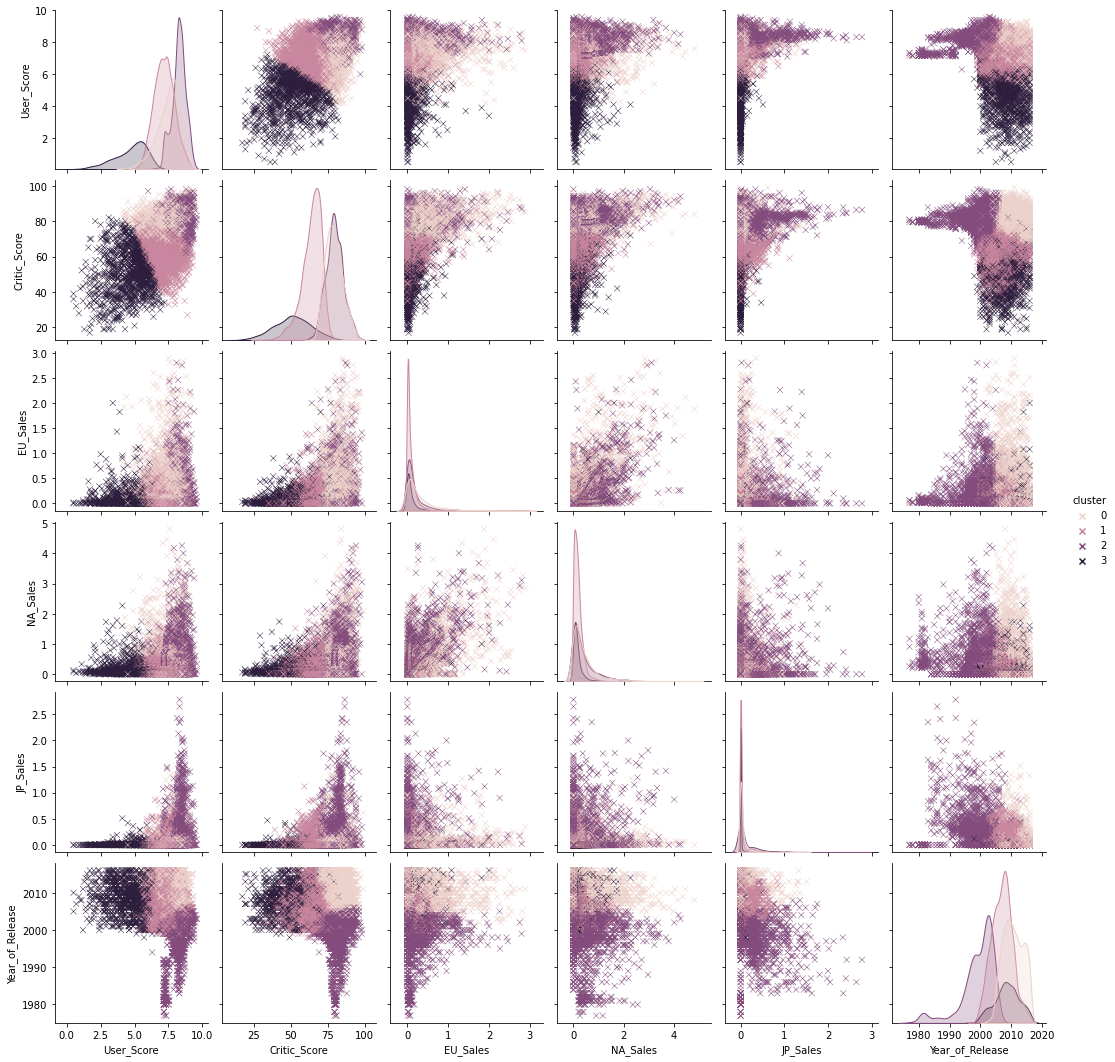

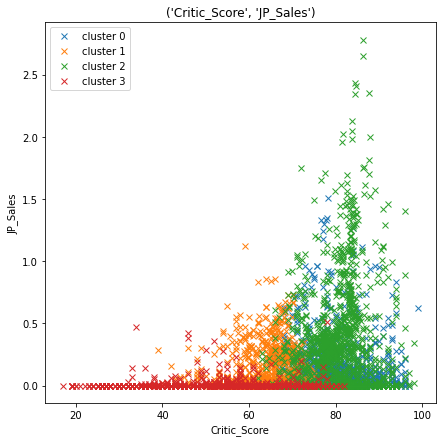

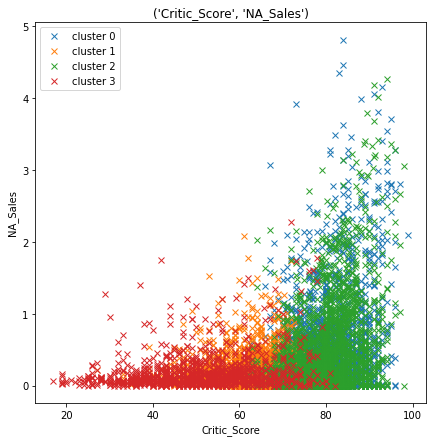

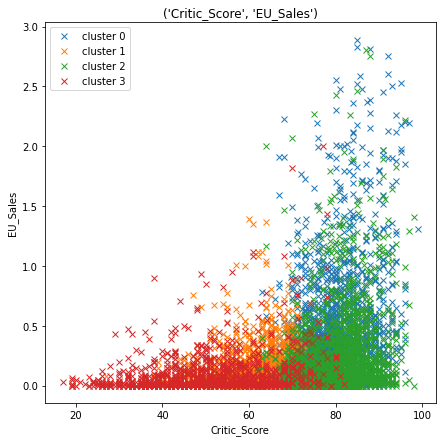

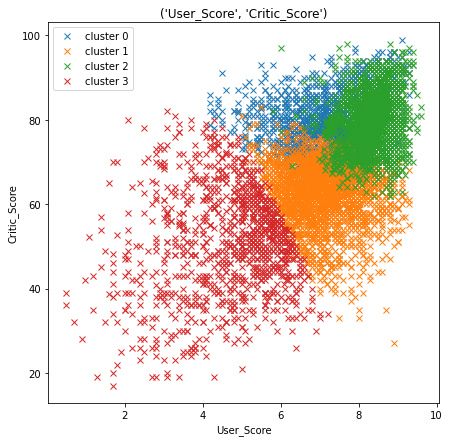

In [54]:
sns.pairplot(data=clustered_data, hue="cluster", markers=['x', 'x', 'x', 'x'])
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "JP_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "EU_Sales"))
plot_2d_data_with_clusters(clustered_data, ("User_Score", "Critic_Score"))

### Clustering results visualisation using PCA

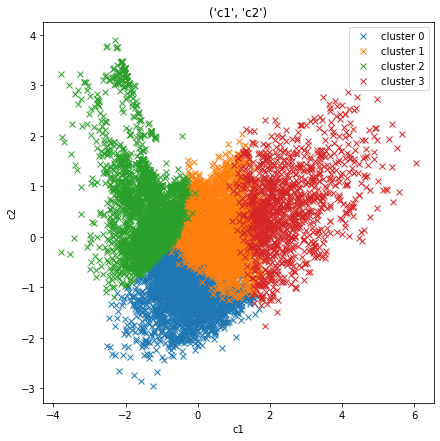

In [55]:
standardize(clustered_data, columns_used_for_clustering, columns_stats)
pca = PCA(n_components=2).fit(clustered_data.filter(columns_used_for_clustering))
reduced = pd.DataFrame(pca.transform(clustered_data.filter(columns_used_for_clustering)), columns=["c1", "c2"], index=clustered_data.index)
reduced.insert(2, "cluster", clustered_data["cluster"])
plot_2d_data_with_clusters(reduced, ("c1", "c2"))
de_standardize(clustered_data, columns_used_for_clustering, columns_stats)

### Clustering analysis - variable distribution for each cluster

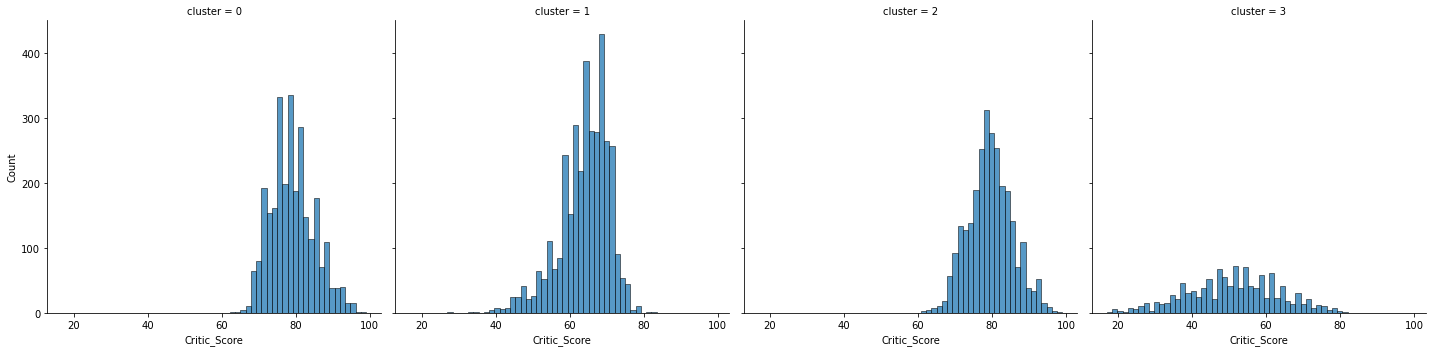

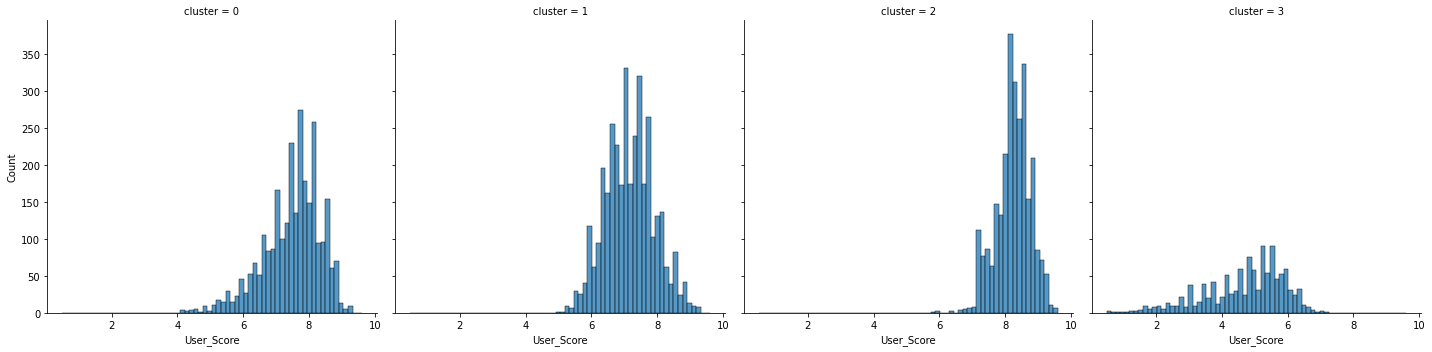

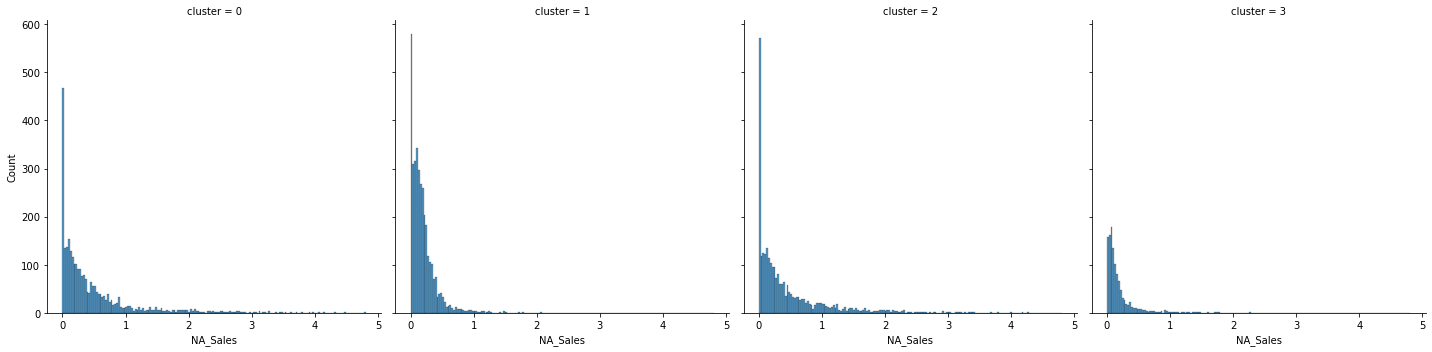

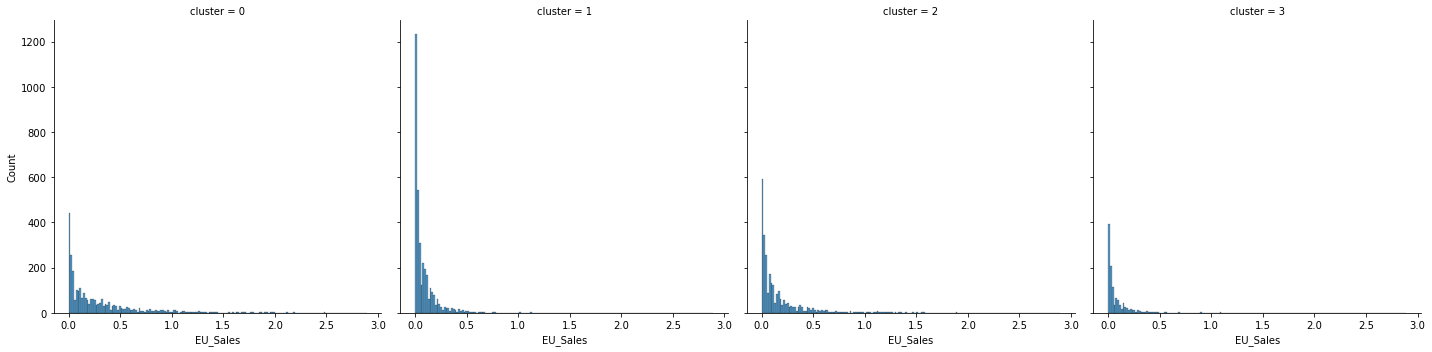

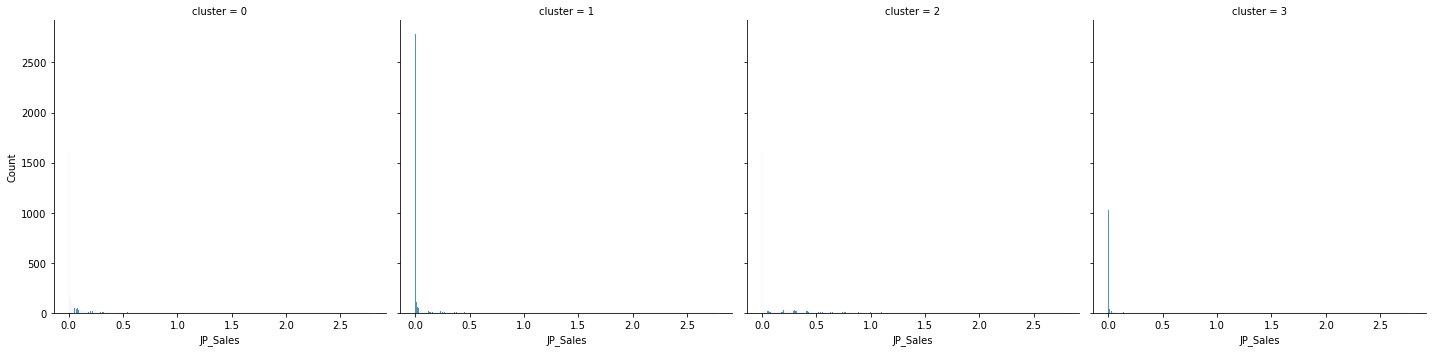

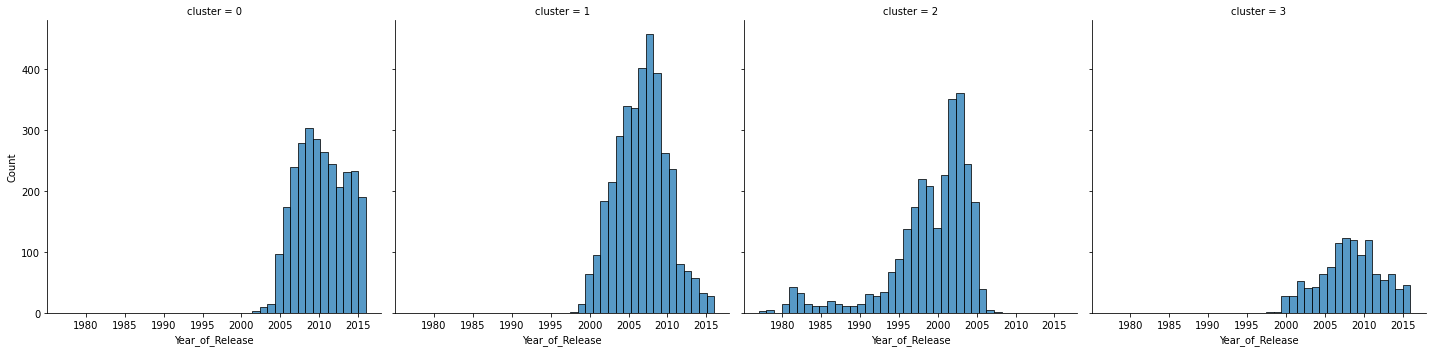

In [56]:
sns.displot(clustered_data, x="Critic_Score", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="User_Score", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="NA_Sales", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="EU_Sales", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="JP_Sales", col="cluster", multiple="dodge")

years = len(range(np.int32(clustered_data["Year_of_Release"].min()), np.int32(clustered_data["Year_of_Release"].max()) + 1))
sns.displot(clustered_data, bins=years, x="Year_of_Release", col="cluster", multiple="dodge")

### Clusters analysis - variables means for each cluster

         User_Score  Critic_Score  EU_Sales  NA_Sales  JP_Sales  \
cluster                                                           
0          7.493001     79.094380  0.314024  0.456859  0.058815   
1          7.177617     63.894149  0.082945  0.185724  0.036827   
2          8.248591     79.463796  0.188697  0.438953  0.180128   
3          4.699002     51.010239  0.094343  0.180700  0.007782   

         Year_of_Release  
cluster                   
0            2010.599424  
1            2006.965120  
2            1999.119708  
3            2008.537543  


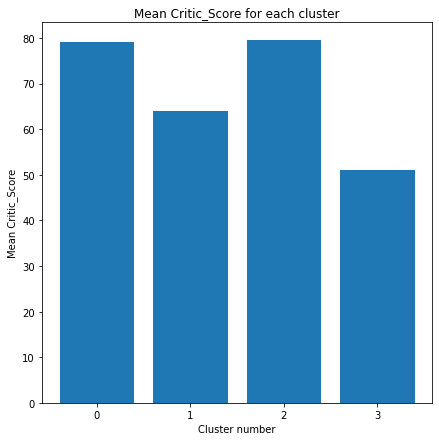

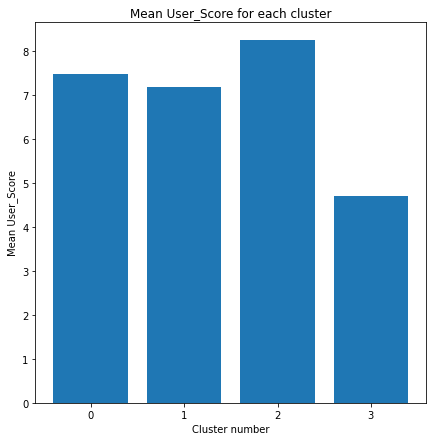

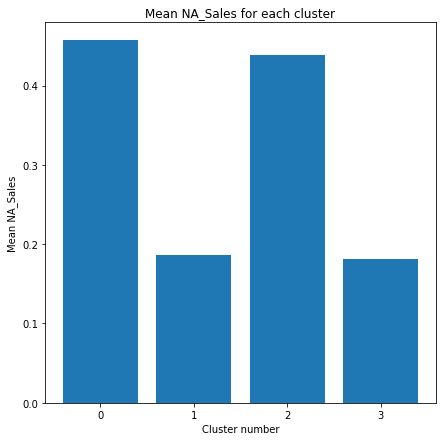

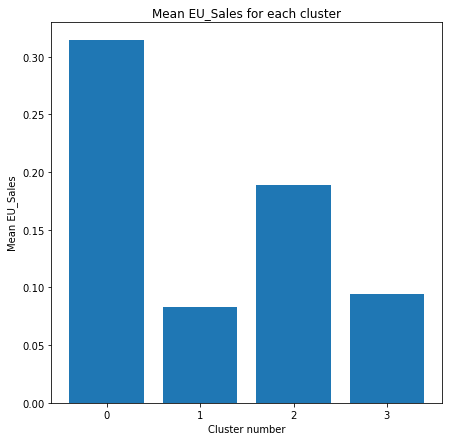

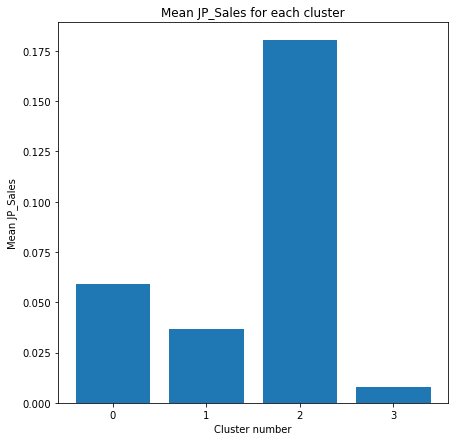

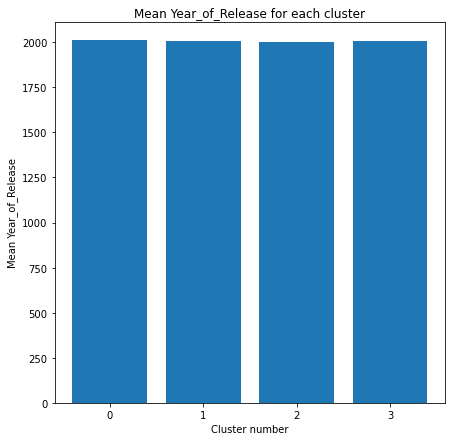

In [57]:
data_means_grouped_by_clusters = clustered_data.groupby("cluster").mean()
print(data_means_grouped_by_clusters)

plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "Critic_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "User_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "NA_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "EU_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "JP_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "Year_of_Release")

### Clusters analysis - categorical variables

<AxesSubplot:xlabel='counts', ylabel='Rating'>

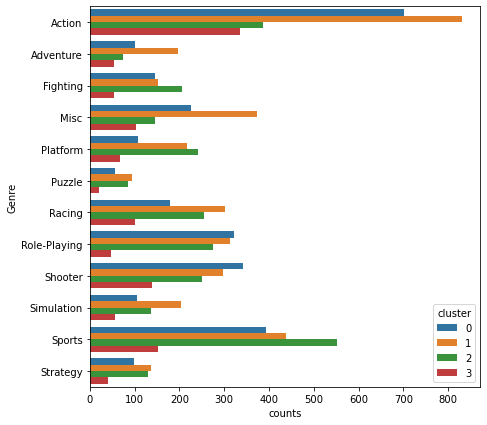

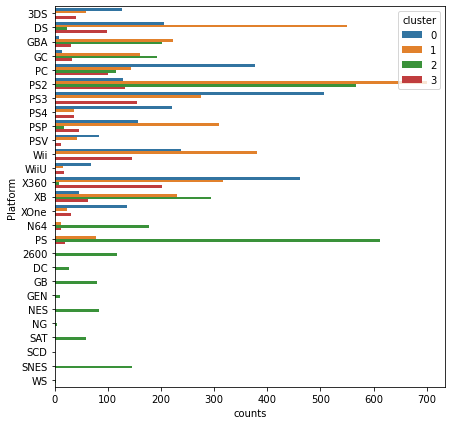

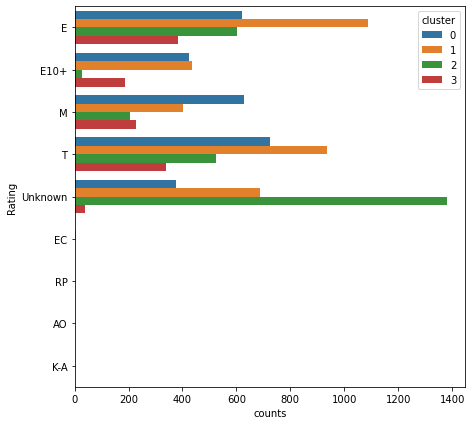

In [58]:
# genres
grouped_by_genre = clustered_data.groupby(["cluster", "Genre"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Genre", hue="cluster", data=grouped_by_genre, orient='h')

# platforms
grouped_by_platform = clustered_data.groupby(["cluster", "Platform"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Platform", hue="cluster", data=grouped_by_platform, orient='h')

# ratings
grouped_by_platform = clustered_data.groupby(["cluster", "Rating"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Rating", hue="cluster", data=grouped_by_platform, orient='h')
